In [1]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import pickle
from sqlite3 import dbapi2 as sqlite
from os import (
    path, listdir,
)
import re
import numpy as np
from process.preprocess import cut_patches

## Data description

## Color Normalization

In [2]:
# connetion to the database

con = sqlite.connect('barley_30m.db')
c = con.cursor()

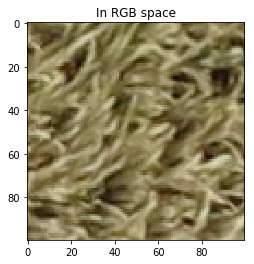

In [3]:
# Example for the rgb and hsv.

a, b = c.execute('select rgb, hsv from img limit 1').fetchone()
plt.imshow(pickle.loads(a))
plt.title('In RGB space')

In [4]:
all_ids = [i for i, in c.execute('select id from img').fetchall()]
ids = np.random.choice(all_ids, size=600)
id_train = np.random.choice(ids, size=500)
id_validation = [i for i in ids if i not in id_train]

img_train = []
img_val = []
label_train = []
label_val = []

for i in id_train:
    rgb, label = c.execute('select rgb, label from img where id=%s' % i).fetchone()
    img_train.append(pickle.loads(rgb))
    if label == 1:
        label_train.append([1, 0])
    else:
        label_train.append([0, 1])

x_tr = np.array(img_train)
y_tr = np.array(label_train)

for i in id_validation:
    rgb, label = c.execute('select rgb, label from img where id=%s' % i).fetchone()
    img_val.append(pickle.loads(rgb))
    if label == 1:
        label_val.append([1, 0])
    else:
        label_val.append([0, 1])

x_val = np.array(img_val)
y_val = np.array(label_val)

In [5]:
import tensorflow as tf

sess = tf.InteractiveSession()

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name="W")


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name="bias")


def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding="SAME", name="conv2d")


def max_pool(x):
    return tf.nn.max_pool(
        x,
        ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1],
        padding="SAME",
        name="pooled")

xs = tf.placeholder(tf.float32, [None, 100, 100, 3])
ys = tf.placeholder(tf.float32, [None, 2])
keep_prob = tf.placeholder(tf.float32)


# conv_1 layer
# with tf.name_scope('conv-layer-1'):
W_conv1 = weight_variable([5, 5, 3, 16]) # outsize=32 :  convolutions units
b_conv1 = bias_variable([16])
h_conv1 = tf.nn.relu(conv2d(xs, W_conv1) + b_conv1) # 100 * 100 * 32
h_pooled_1 = max_pool(h_conv1) # 50 * 50 * 32


# conv_2 layer
#with tf.name_scope('conv-layer-2'):
W_conv2 = weight_variable([5,5,16,8]) # outsize=64
b_conv2 = bias_variable([8])
h_conv2 = tf.nn.relu(conv2d(h_pooled_1, W_conv2) + b_conv2) # 25 * 25 *64
h_pooled_2 = max_pool(h_conv2) # 25 * 25 * 64


# func1 layer
# with tf.name_scope('nn-layer-1'):
W_fun1 = weight_variable([25*25*8, 1024])
b_fun1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pooled_2, [-1, 25*25*8])
h_fun2 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fun1) + b_fun1)
h_fun2_drop = tf.nn.dropout(h_fun2, keep_prob)


# func2 layer
# with tf.name_scope('nn-layer-2'):
W_fun2 = weight_variable([1024, 2])
b_fun2 = bias_variable([1])
# softmax
prediction = tf.nn.softmax(tf.matmul(h_fun2_drop, W_fun2) + b_fun2)
# logic regression
# prediction = tf.nn.sigmoid(tf.matmul(h_fun2_drop, W_fun2) + b_fun2)

# cost_function = tf.reduce_mean(tf.reduce_sum(-(ys * tf.log(prediction))- ((1 - ys) * tf.log(1 - prediction))))
cross_entropy = tf.reduce_mean(-tf.reduce_sum(ys * tf.log(prediction)))
train_step = tf.train.AdamOptimizer(1e-04).minimize(cross_entropy)
# train_step = tf.train.AdamOptimizer(1e-04).minimize(cost_function)
# accuracy
correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(ys, 1))
# correct_prediction = tf.equal(tf.round(prediction), ys)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess.run(tf.initialize_all_variables())

a = []
b = []

for i in range(200):
    train_accuacy = accuracy.eval(feed_dict={xs: x_tr, ys: y_tr, keep_prob: 1})
    a.append(train_accuacy)
    test_accuracy = accuracy.eval(feed_dict={xs: x_val, ys: y_val, keep_prob: 1})
    b.append(test_accuracy)
    if i % 10 == 0:
        print("step %d, training accuracy %g"%(i, train_accuacy))
        print("test accuracy %g"%test_accuracy)
    train_step.run(feed_dict = {xs: x_tr, ys: y_tr, keep_prob: 0.5})

# accuacy on test
print("test accuracy %g"%(accuracy.eval(feed_dict={xs: x_val, ys: y_val, keep_prob: 1})))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
step 0, training accuracy 0.382
test accuracy 0.419048
step 10, training accuracy 0.538
test accuracy 0.480952
step 20, training accuracy 0.696
test accuracy 0.580952
step 30, training accuracy 0.78
test accuracy 0.685714
step 40, training accuracy 0.77
test accuracy 0.704762
step 50, training accuracy 0.82
test accuracy 0.685714
step 60, training accuracy 0.836
test accuracy 0.704762
step 70, training accuracy 0.884
test accuracy 0.733333
step 80, training accuracy 0.904
test accuracy 0.742857
step 90, training accuracy 0.936
test accuracy 0.757143
step 100, training accuracy 0.944
test accuracy 0.761905
step 110, training accuracy 0.95
test accuracy 0.761905
step 120, training accuracy 0.968
test accuracy 0.780952
step 130, training accuracy 0.98
test accuracy 0.780952
step 140, training accuracy 0.988
test accuracy 0.790476
step 150, training accuracy 0.996
test accuracy 0.795238
step 160, training accuracy 0.

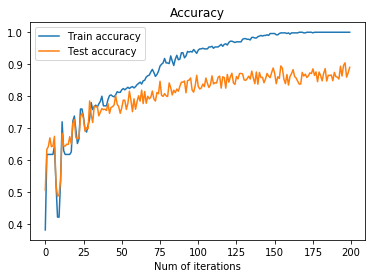

In [17]:
plt.plot(a)
plt.plot(b)
plt.title('Accuracy')
plt.xlabel('Num of iterations')
plt.legend(['Train accuracy', 'Test accuracy'])

(-0.5, 99.5, 99.5, -0.5)

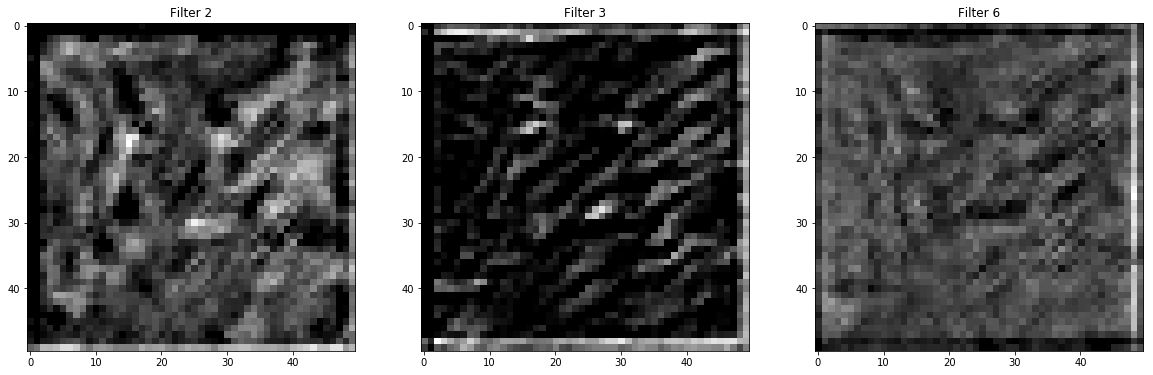

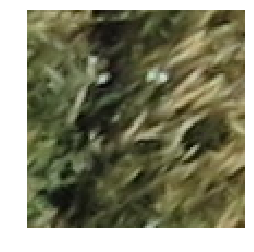

In [7]:
import math
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={xs: stimuli,keep_prob:1.0})
    plotNNFilter(units)
    
def plotNNFilter(units):
    filters = [2, 3, 6]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    for j, i in enumerate(filters):
        plt.subplot(1, 3, j+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")
        
getActivations(h_conv2, x_tr[3:4, :, :, :])
plt.figure()
plt.imshow(x_tr[3, :, :, :])
plt.axis('off')